In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'


In [2]:

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

traces = []
models = []
for num_change_points in range(4):
    model = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                        change_points_list = change_points[:num_change_points],
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6,
                                        priors_dict=None)
    models.append(model)

    traces.append(pm.sample(model=model, init='advi', draws=4000))

Cases yesterday (2020-04-17T00:00:00): 141397 and day before yesterday: 137698
pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 466.71:   7%|▋         | 13487/200000 [00:20<04:43, 659.05it/s]
Convergence achieved at 13500
Interrupted at 13,499 [6%]: Average Loss = 634.43
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, lambda_0, I_begin]
Sampling 4 chains, 115 divergences: 100%|██████████| 18000/18000 [03:51<00:00, 77.62draws/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7214174251948886, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [13:26<00:00, 22.31draws/s]
The number of effective samples is smaller than 25% for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 1 was set to default value 3
pr_sigma_transient_len of change point 1 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 452.65:   7%|▋         | 14192/200000 [00:22<04:59, 619.70it/s]
Convergence achieved at 14200
Interrupted at 14,199 [7%]: Average Loss = 587.19
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_1, transient_len_0, transient_begin_1, transient_begin_0, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences:  53%|█████▎    | 9500/18000 [07:47<07:32, 18.77draws/s]

NameError: name 'conv_time_to_mpl_dates' is not defined

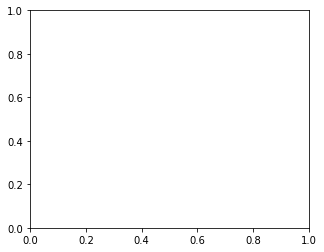

In [3]:
fig, ax = plt.subplots(figsize=(5,4))
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
ax.plot(mpl_dates, np.abs(np.median(trace.new_cases[:, :num_days_data], axis=0) - np.diff(cases_obs)), 
        'd', markersize=6,
         label='Absolute difference\n'
               'between fit and data')
ax.plot(mpl_dates, np.sqrt(np.median(trace.new_cases[:, :num_days_data], axis=0))*np.median(trace.sigma_obs, axis=0),
         label='Width of the likelihood', lw=3)
ax.set_ylabel('Difference (number of new cases)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
print(np.median(np.sum(trace.new_cases[:, :num_days_data], axis=1)+ trace.I_begin))
#plt.tight_layout()
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))


In [4]:
exec(open('figures.py').read())

[<Figure size 576x144 with 4 Axes>, <Figure size 468x540 with 3 Axes>]

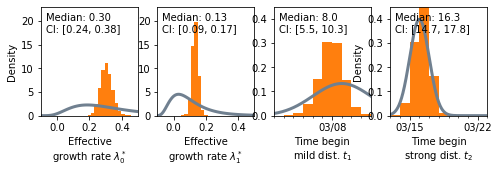

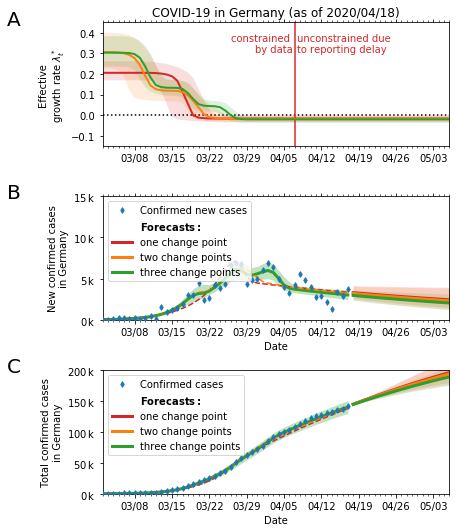

In [5]:
create_figure_0(save_to = path_to_save)

[<Figure size 288x432 with 5 Axes>,
 <Figure size 288x432 with 5 Axes>,
 <Figure size 288x432 with 5 Axes>]

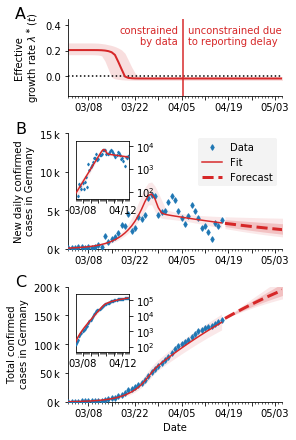

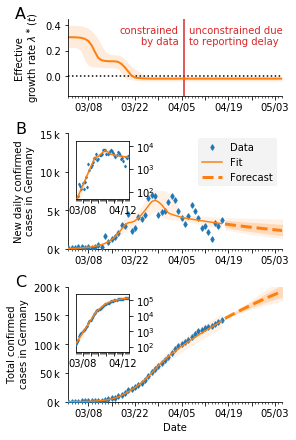

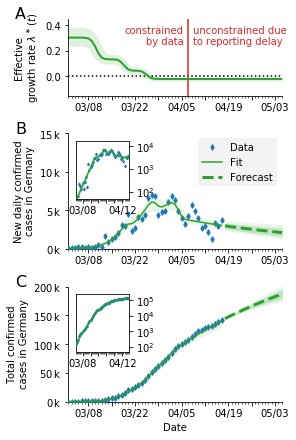

In [6]:
create_figure_3_timeseries(save_to=path_to_save)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1535: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1535: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1535: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


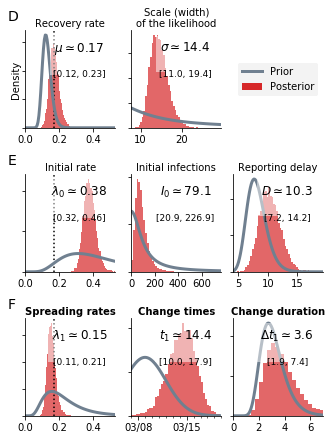

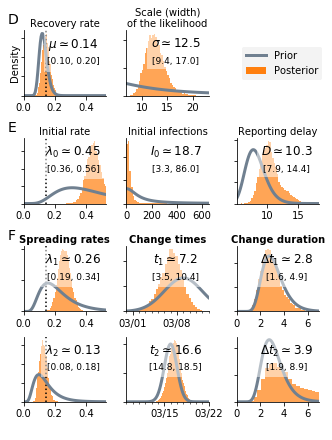

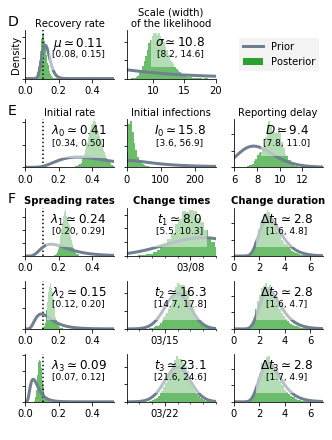

In [7]:
create_figure_3_distributions(models[1], traces[1], layout=2,
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:red',
                              num_changepoints=1, xlim_tbegin=7, save_to = path_to_save +'Fig_S2')
create_figure_3_distributions(models[2], traces[2], layout=2,
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:orange',
                              num_changepoints=2, xlim_tbegin=7, save_to = path_to_save +'Fig_4')
create_figure_3_distributions(models[3], traces[3], layout=2,
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, save_to = path_to_save + 'Fig_S4')

In [8]:
print('\n0 step model\n')
print(pm.loo(traces[0], model))

print('\n1 step model\n')
print(pm.loo(traces[1], model))

print('\n2 steps model\n')
print(pm.loo(traces[2], model))

print('\n3 steps model\n')
print(pm.loo(traces[3], model))


0 step model

Computed from 16000 by 47 log-likelihood matrix

       Estimate       SE
IC_loo   848.77    10.59
p_loo      5.50        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46   97.9%
 (0.5, 0.7]   (ok)          1    2.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


1 step model



/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 16000 by 47 log-likelihood matrix

       Estimate       SE
IC_loo   765.09    16.29
p_loo      6.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46   97.9%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    2.1%
   (1, Inf)   (very bad)    0    0.0%


2 steps model

Computed from 16000 by 47 log-likelihood matrix

       Estimate       SE
IC_loo   755.33    17.87
p_loo     11.72        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       47  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


3 steps model

Computed from 16000 by 47 log-likelihood matrix

       Estimate       SE
IC_loo   738.59    17.23
p_loo      8.98        -
------

Pareto k diagnostic values:
                         Count

In [9]:
for i in range(4):
    print('λ_{}*: '.format(i))
    print(print_median_CI(trace['lambda_{}'.format(i)] - trace.mu, prec=3))
    print('\n')

λ_0*: 


NameError: name 'trace' is not defined